# **Machine Learning Lab 4EII - IA course**

## 1- **Introduction**

This lab aim at using simple **deep learning** classifier only with Python (without external framework) for a classification problem of recognizing handwritten digits. We consider ten digits 0 to 9 from MNIST dataset, with using Neural Network (NN) with two layers (one hidden layer). 

In this lab you will learn to:
* Build you own two layers NN with Python
* Build different steps of NN: forward, backward propagations, loss function and activation functions.
* Study the performance and hyper-parameters of NN
* Build a NN and CNN with using Keras module

The architecture and parameters of the two layers NN are shown in this figure. 


![architecture and parameters of the two layers NN](https://drive.google.com/uc?id=1-DkY2Of_l7MBXnz9vEZ8jvxh-I_vEK0q)

## 2- **Module importation**
Import some useful and common python modules 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import progressbar
import time

## 3- **Download and study the the MNIST dataset**



### 3.a - Download the MNIST dataset

MNIST dataset contains 70000 images of handwritten digits from 0 to 9. The dataset contains images of size 28x28 pixels and the corresponding labels

In [2]:
mnist = fetch_openml('mnist_784') #You can also use and test mnist_784/Fashion-MNIST dataset  

### 3.b - Create a class structure to save and analyse the dataset

In [3]:
def computeentropy(image):
    lensig=image.size
    symset=list(set(image))
    numsym=len(symset)
    propab=[np.size(image[image==i])/(1.0*lensig) for i in symset]
    ent=np.sum([p*np.log2(1.0/p) for p in propab])
    return ent;

class Digit:
    def __init__(self, data, target):
        self.width      = int(np.sqrt((len(data))))
        self.target     = target;
        self.image      = data;

        self.features   = {
                            'var'        :0.0, 'std'        :0.0,
                            'mean'       :0.0, 'entropy'    :0.0,
                          }
        self.computeFeatures()

    def computeFeatures(self):
        self.features['var'] = round(np.var(self.image),2)
        self.features['std'] = round(np.std(self.image),2)
        self.features['mean'] = round(np.mean(self.image),2)
        self.features['entropy'] = round(computeentropy(self.image),2)

    def print(self):
        print("Digit target: " + str(self.target))
        print("Digit target size: "+ str(self.width)  + "x" +str(self.width) + 
              '| mean : ' + str(self.features['mean']) +
              '| var : ' + str(self.features['var']) + 
              '| std :' + str(self.features['std']) + 
              '| entropy :' + str(self.features['entropy']))
        print("Digit image:")
        plt.figure()
        plt.gray()
        plt.matshow(self.image.reshape(self.width, self.width)) 
        plt.savefig(str(self.target)+'.png', bbox_inches='tight')
        plt.show() 
    def getWidth(self):
        return self.width;


class Dataset:    
    def __init__(self, data, size=0, nb_classes=10):  
        self.length = int((len(data['data'])))
        if size > 0 and size <  self.length:
            self.length = size;
        else:
            size = self.length;  

        self.targets  = data['target'][0:size]
        self.data = data['data'][0:size];
        self.digits       = [];
        self.nb_classes = nb_classes; 
        self.createDigits()
        self.X_train = []; 
        self.X_test = []; 
        self.y_train = []; 
        self.y_test = [];  

    def printInfo(self):
        from collections import Counter

        c = Counter(self.targets)
        info = "Dataset size " + str(self.length)
        key_value = {} 
        for i in sorted(c.keys()):
            key_value[i] = c[i];

        plt.bar(key_value.keys(), key_value.values());
        plt.xlabel('Labels')
        plt.ylabel('Occurrence')
        plt.title('Occurrence of MNIST dataset labels')
        ax = plt.axes()        
        ax.grid(which='major', axis='y')
        plt.show()
        return info

    def createDigits(self):
        bar = progressbar.ProgressBar(maxval=self.length).start()
        for i in range(self.length):
            self.digits.append(Digit(self.data[i], self.targets[i]))
            bar.update(i+1);

    def separate_train_test(self, test_size_ratio):
        from sklearn.model_selection import train_test_split 
        import keras

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.data, self.targets, test_size=test_size_ratio)
        # data normalization   
        self.X_train = self.X_train/255;
        self.X_test  = self.X_test/255;

        self.X_train = self.X_train.astype('float32')
        self.X_test = self.X_test.astype('float32')
        print('Size of training set : ' + str(len(self.y_train)) + ' / ' + str(len(self.data)));
        print('Size of testing set : ' + str(len(self.y_test))+ ' / ' + str(len(self.data)));
        self.X_train  = self.X_train.reshape(len(self.X_train), self.digits[0].getWidth()*self.digits[0].getWidth())  # reshape input from (28,28) to 784
        self.X_test   = self.X_test.reshape(len(self.X_test), self.digits[0].width*self.digits[0].width)
        self.X_train  = self.X_train.astype('float32')
        self.X_test   = self.X_test.astype('float32')

        self.Y_train = keras.utils.to_categorical(self.y_train, self.nb_classes)
        self.Y_test = keras.utils.to_categorical(self.y_test, self.nb_classes)

    def reshapeinImage(self):
        width = self.digits[0].width; 
        self.X_train = self.X_train.reshape(self.X_train.shape[0], width, width, 1)
        self.X_test  = self.X_test.reshape(self.X_test.shape[0], width, width, 1)


    def display_train_test(self):
        from collections import Counter

        test = Counter(self.y_test)
        train = Counter(self.y_train)
        info = "Dataset size " + str(self.length) 

        key_value_train = {};
        key_value_test = {};

        for i in sorted(test.keys()):
            key_value_test[i] = test[i];
        for i in sorted(train.keys()):
            key_value_train[i] = train[i];

        p1 = plt.bar(key_value_train.keys(), key_value_train.values(), width=0.5);
        p2 = plt.bar( key_value_test.keys(), key_value_test.values(), width=0.5, bottom=list(key_value_train.values()) ); 

        plt.legend((p1[0], p2[0]), ('Training set', 'Test set'), loc='lower left')
        plt.xlabel('Labels')
        plt.ylabel('Occurrence')
        plt.title('Occurrence of training and testing sets')
        ax = plt.axes()        
        ax.grid(which='major', axis='y')
        plt.show();    

### 3.b - Load the MNIST dataset in Dataset class and analyse it: 
1.   Load the dataset in Dataset class 

*samples* is the number of considered samples (sub-set) over 700000 of MNIST dataset, it enables faster training and testing



In [4]:
samples = 0; # All pictures 
training_set = Dataset(mnist, samples) 

2.   Display some digist with corresponding features  

Digit target: 5
Digit target size: 28x28| mean : 35.11| var : 6343.94| std :79.65| entropy :1.83
Digit image:


<Figure size 432x288 with 0 Axes>

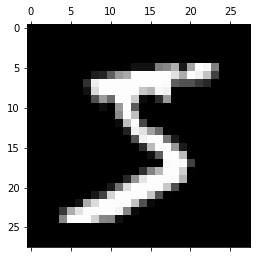

Digit target: 0
Digit target size: 28x28| mean : 39.66| var : 7037.06| std :83.89| entropy :1.92
Digit image:


<Figure size 432x288 with 0 Axes>

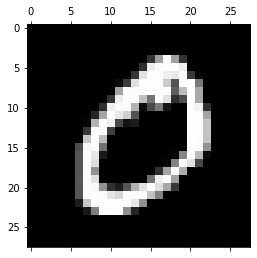

Digit target: 4
Digit target size: 28x28| mean : 24.8| var : 4300.7| std :65.58| entropy :1.46
Digit image:


<Figure size 432x288 with 0 Axes>

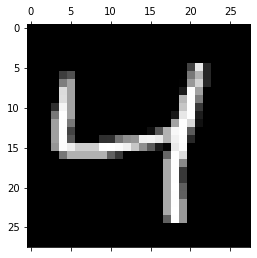

Digit target: 1
Digit target size: 28x28| mean : 21.86| var : 4366.42| std :66.08| entropy :1.1
Digit image:


<Figure size 432x288 with 0 Axes>

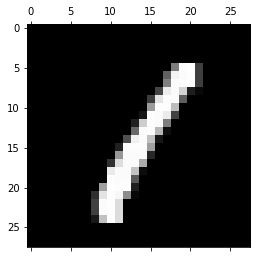

Digit target: 9
Digit target size: 28x28| mean : 29.61| var : 5531.09| std :74.37| entropy :1.61
Digit image:


<Figure size 432x288 with 0 Axes>

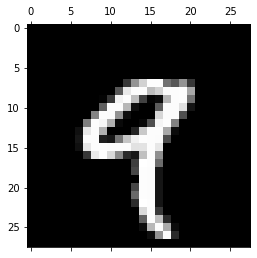

Digit target: 2
Digit target size: 28x28| mean : 37.76| var : 6577.97| std :81.1| entropy :2.11
Digit image:


<Figure size 432x288 with 0 Axes>

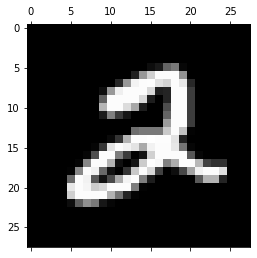

Digit target: 1
Digit target size: 28x28| mean : 22.51| var : 4602.49| std :67.84| entropy :0.94
Digit image:


<Figure size 432x288 with 0 Axes>

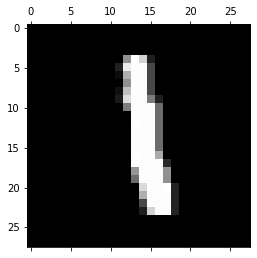

Digit target: 3
Digit target size: 28x28| mean : 45.75| var : 8102.99| std :90.02| entropy :1.99
Digit image:


<Figure size 432x288 with 0 Axes>

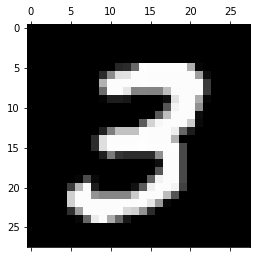

Digit target: 1
Digit target size: 28x28| mean : 13.87| var : 2768.36| std :52.62| entropy :0.81
Digit image:


<Figure size 432x288 with 0 Axes>

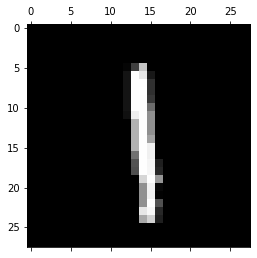

Digit target: 4
Digit target size: 28x28| mean : 27.94| var : 5120.58| std :71.56| entropy :1.59
Digit image:


<Figure size 432x288 with 0 Axes>

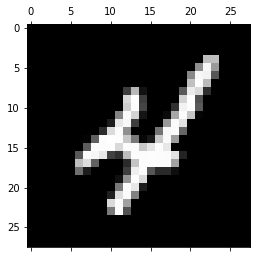

In [5]:
samples_to_diplay = 10;
for i in range(samples_to_diplay):
  training_set.digits[i].print()

3.   Display digits repartitions with *printInfo* function of *Dataset* class

*   Is the dataset well balanced ?





<ipython-input-3-3b803e6231f3>:75: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


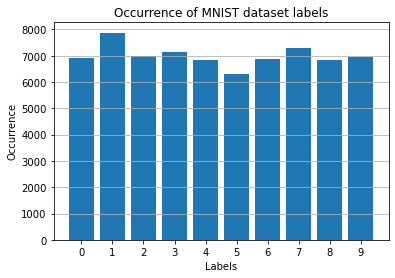

'Dataset size 70000'

In [6]:
training_set.printInfo()

## 4 - **Dataset preparation**


> The MNIST dataset is split to training and testing sets with the corresponding labels



### 4.a - Split the the MNIST dataset in training and testing sets 

*   Use *separate_train_test* function with a test set split ratio as parameter 
*   The test and train sets will be loaded in X_train and X_test lists and the corresponding labels in y_train and y_test lists. 




In [7]:
test_ratio = 0.25;
training_set.separate_train_test(test_ratio)

Size of training set : 52500 / 70000
Size of testing set : 17500 / 70000


### 4.b - Display the repartition of the digits 

*   Use  *display_train_test* function to illustrate the digits' repartition 
*   Check whether the repartition ratio is correct 



<ipython-input-3-3b803e6231f3>:135: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = plt.axes()


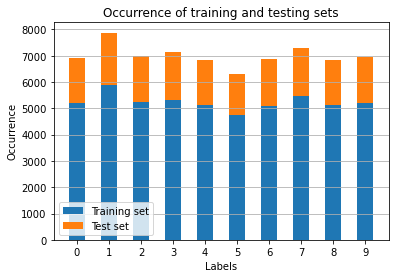

In [8]:
training_set.display_train_test()

## 5 - **Define the diffrent functions of the NN**


### 5.a - Activation fucntion

> Define the activation functions used in forward and bachward propagations

> Implement three activations functions seen in the MIT DL course: sigmoid, Hyperbolic Tangent and Rectified Linear Unit (ReLU) in forward and backward processes. Use numpy module functions such as *np.maximum* and *np.exp* 

In [9]:
class myActivationFun(object):
  
    def softMax(x):
        '''
        always used on the last dense layers. It returns a value in the interval [0, 1] probability
        '''
        exps = np.exp(x - np.max(x))
        return exps / np.sum(exps, axis=0)

    def forward(x, actF):
        if(actF =='ReLu'):
            # TO DO
            return np.maximum(0, x) 
        elif(actF =='Sigmoid'):
            # TO DO
            return 1/(1 + np.exp(-x))
        elif (actF =='tanh'): 
            # TO DO
            return np.tanh(x)
        else: 
            print('Error this activation function '+ actF + ' is not supported, we consider ReLu');
            return np.maximum(0, x)     

    def backward(x, actF):
        if(actF =='ReLu'):
            # TO DO
            return np.maximum(0, np.sign(x))
        elif(actF =='Sigmoid'):
            # TO DO
            return 1/(1+np.exp(-(x)))*(1-1/(1+np.exp(-x)));
        elif (actF =='tanh'): 
            # TO DO
            return 1 - np.power(np.tanh(x), 2)
        else: 
            print('Error this activation function '+ actF + ' is not supported, we consider ReLu');
            return np.maximum(0, np.sign(x))


### 5.b - Cross entropy loss function 


> Define the cross entropy loss function
Use numpy module functions such as *np.multiply* and *np.log*   


In [10]:
class MyCrossEntropy(object):
    def costFun(y, yt):
        return -np.sum(np.multiply(yt,np.log(y)),axis=0)

## 6 - **Build the architecture of the NN**

 In this section you will build the architecture of the NN in five mains steps:


1.   Initialization of the parameters 
2.   Forward Process
3.   Backward Process
4.   Train the network 
5.   Predict the output 


## 6.a Parameters initialization 

In [11]:
class Neural_Network:
    def __init__(self, dataset, nb_classes=10, nb_hiden_layers=1, 
                 batch_size=128, hiden_layer_size=300, activFunc = "ReLu"):
        self.dataset     = dataset;
        self.nb_layers   = nb_hiden_layers+1;
        self.nb_classes  = nb_classes; 
        self.output_size  = nb_classes;
        self.Mini_batch_size  = batch_size;
        self.train_set_size,self.input_size = self.dataset.X_train.shape
        self.hiden_layer_size  = hiden_layer_size;
        self.activFunc = activFunc;
        self.Initilize_NN()

    def Initilize_NN(self):
        self.sig   = 0.05;
        self.lambd = 0.01;
        self.W = [0]*self.nb_layers;

        # Initialize the weights with a normal distribution 
        self.W[0] = self.sig*np.random.randn(self.hiden_layer_size, self.input_size+1) # input layer 
        for i in range(1, self.nb_layers-1):
            self.W[i] = self.sig*np.random.randn(self.hiden_layer_size, self.hiden_layer_size+1)   # hiden layers 
        self.W[self.nb_layers-1] = self.sig*np.random.randn(self.output_size, self.hiden_layer_size+1) # output layers 

    def forward (self, ind):
        l = [];
        h  = self.dataset.X_train[ind,].T
        l.append(h);

        for i in range(self.nb_layers):
            a = np.matmul(self.W[i], np.r_[h, np.ones((1, self.Mini_batch_size))])

            if(i != self.nb_layers-1): # Aplly ReLu operation 
                l.append(a);
                h = myActivationFun.forward(a, self.activFunc)
            else: # Apply SoftMax for the last layer 
                h = myActivationFun.softMax(a);

            l.append(h);
        return l;

    def backward(self, l, ind, exps):
        gradW = [0]*self.nb_layers;
        stepsize = 0.1/self.Mini_batch_size;

        dJ_da  = exps - self.dataset.Y_train[ind,].T
        for i in range(self.nb_layers):
            gradW[self.nb_layers-i-1] = np.matmul(dJ_da , np.r_[l.pop(), np.ones((1,self.Mini_batch_size))].T) + self.lambd*self.W[self.nb_layers-i-1]     
            if(i != self.nb_layers-1):
                dJ_da = np.matmul(self.W[self.nb_layers-i-1][:,0:self.hiden_layer_size].T, dJ_da) * myActivationFun.backward(l.pop(), self.activFunc)      
            self.W[self.nb_layers-i-1] = self.W[self.nb_layers-i-1] - stepsize*gradW[self.nb_layers-i-1];

    def train(self, nb_epoch=50):
        t0=time.time()
        nb_ite_max = int(np.round(nb_epoch*self.train_set_size/self.Mini_batch_size));
        bar = progressbar.ProgressBar(maxval=nb_ite_max).start()
        idx = 0;
        for itr in range(nb_ite_max):
            ind = np.random.choice(np.arange(self.train_set_size),self.Mini_batch_size, replace=False)
            l = NN.forward(ind);
            exps = l.pop();
            err = MyCrossEntropy.costFun(exps, self.dataset.Y_train[ind,].T);
            #print(np.sum(err))
            NN.backward(l, ind, exps);
            idx +=1;
            bar.update(idx)
        print('total computing time: '+str(time.time()-t0))


    def predict(self):
        test_set_size,p = self.dataset.X_test.shape;
        y = self.dataset.X_test.T;

        for i in range(self.nb_layers):
            h = np.matmul(self.W[i], np.r_[y, np.ones((1,test_set_size))])
            if(i != self.nb_layers-1): # Aplly ReLu operation 
                # TO DO
                y = myActivationFun.forward(h, self.activFunc)
            else: # Apply SoftMax for the last layer 
                # TO DO
                y = myActivationFun.softMax(h)

        winner = y.max(0).reshape((test_set_size,1))
        yp = (y == np.outer(np.ones((10,1)),winner)).astype(int)
        err_rate = 100*np.sum(np.abs(yp - self.dataset.Y_test.T))/test_set_size/2
        print('Error rate:  %4.2f %%'% err_rate)


 ###  5.d - Train the Neural Network 

> Perform Neural Network training 
1.   Create an instance of Neural_Network class 
2.   Perform prediction on the testing set
3.   Train the created Neural Network 
4.   Perform prediction again on the testing set

> Compare the performance of the NN with the benchmark on [MNIST](http://yann.lecun.com/exdb/mnist/index.html) and [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) datasets, which one is more challenging to classify

> Test your NN with different activation functions 

> Does increasing the number of hidden layers enhance the NN performance 

> What is the impact of the training rate of the NN performance ?

> How many parameters are trained in this NN

> Why the performance may slighly change between two simulations

> Train the network with three layers



3 layers

In [12]:
%%script false --no-raise-error
NN = Neural_Network(training_set, batch_size=128, nb_hiden_layers=3, hiden_layer_size=350);
print('Error rate before training : ')
# TO DO
NN.predict()

print('Training -------------------------------')
# TO DO
NN.train()


print('Testing -------------------------------')
# TO DO
NN.predict()

5 layers

In [13]:
%%script false --no-raise-error
NN = Neural_Network(training_set, batch_size=128, nb_hiden_layers=5, hiden_layer_size=350);
print('Error rate before training : ')
# TO DO
NN.predict()

print('Training -------------------------------')
# TO DO
NN.train()


print('Testing -------------------------------')
# TO DO
NN.predict()

8 layers

In [14]:
%%script false --no-raise-error
NN = Neural_Network(training_set, batch_size=128, nb_hiden_layers=8, hiden_layer_size=350);
print('Error rate before training : ')
# TO DO
NN.predict()

print('Training -------------------------------')
# TO DO
NN.train()


print('Testing -------------------------------')
# TO DO
NN.predict()

5 Layers using Sigmoid activation function

In [15]:
%%script false --no-raise-error
NN = Neural_Network(training_set, batch_size=128, nb_hiden_layers=5, hiden_layer_size=350, activFunc="Sigmoid");
print('Error rate before training : ')
# TO DO
NN.predict()

print('Training -------------------------------')
# TO DO
NN.train()


print('Testing -------------------------------')
# TO DO
NN.predict()

> Run again prediction  

In [16]:
%%script false --no-raise-error
def predict(NN):
    nt,p = NN.dataset.X_test.shape;
    y = NN.dataset.X_test.T;
    for i in range(NN.nb_layers):
        h = np.matmul(NN.W[i], np.r_[y, np.ones((1,nt))])
        if(i != NN.nb_layers-1): # Aplly ReLu operation 
            # TO DO
            y = myActivationFun.forward(h,"ReLu")
        else: # Apply SoftMax for the last layer 
            # TO DO
            y = myActivationFun.softMax(h)
  
    winner = y.max(0).reshape((nt,1))    
    yp = (y == np.outer(np.ones((10,1)),winner)).astype(int)
    err_rate = 100*np.sum(np.abs(yp - NN.dataset.Y_test.T))/nt/2
    print('Test error rate:  %4.2f %%'% err_rate)
    return yp;
print("5 Layers - ReLu")
y_hat = predict(NN).T;

2.   Compute the [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) of the selected best performing solution and display it with *plot_confusion_matrix* function

> What are the most difficult digits to predict ? Support your answer with numbers from the confusion matrix.





In [17]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.3f}".format(cm[i, j]),
                  horizontalalignment="center",
                  color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                    horizontalalignment="center",
                    color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

Confusion Matrix for 5 Layers Solution and ReLu activation function

In [18]:
%%script false --no-raise-error
from sklearn.metrics import confusion_matrix
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'];
titles_options = [("Confusion matrix, without normalization", False),
                  ("Normalized confusion matrix", True)]


n, c = y_hat.shape
y_hat1 = np.zeros(n);
y1 = np.zeros(n); 
for i in range(n):
    y_hat1[i] = class_names[ int(np.where(y_hat[:][i]==1)[0]) ];
    y1[i] = class_names[ int(np.where(NN.dataset.Y_test[:][i]==1)[0]) ];

conf_mx = confusion_matrix( y1, y_hat1);
plt.figure(figsize=(10,6))  
for title, normalize in titles_options:
    disp = plot_confusion_matrix(cm=conf_mx,
                                 target_names=class_names,
                                 title=title,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)

## 6- Build a NN with using Keras module 



> Now, you can configure Colab to use GPU go to: Execution -> Modifier le type d'execution and select GPU. You can check the model of your GPU by running the code below 

In [19]:
import tensorflow as tf


tf.test.gpu_device_name()
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9165054176920261439,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3376414720
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12465788060057284705
 physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

> Import keras related modules 


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow import keras
import time

### 6-a Create a 2 layers NN rachitecture 

In [21]:
NN2 = Sequential()
NN2.add(Dense(units=300, activation='relu', input_dim=784))
NN2.add(Dense(units=10, activation='softmax'))
NN2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                3010      
Total params: 238,510
Trainable params: 238,510
Non-trainable params: 0
_________________________________________________________________


### 6.b Train the NN model  

In [22]:
NN2.compile(loss      = 'categorical_crossentropy',
           optimizer = keras.optimizers.SGD(), 
           metrics   = ['accuracy'])
t0=time.time()
NN2.fit(training_set.X_train, training_set.Y_train, epochs=10, verbose=0)
print('')
print('total computing time: '+str(time.time()-t0))


total computing time: 18.894487142562866


### 6.c Test the NN model 

In [23]:
score = NN2.evaluate(training_set.X_test, training_set.Y_test)  
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])

547/547 [==============================] - 1s 1ms/step - loss: 0.1769 - accuracy: 0.9497
Test loss: 0.177 
Test err:  5.03 %


### 6.d Test the 2-layers NN with diffrent optimizers 
> Here you can use optimizes you have seen in the MIT course: SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False), Adadelta(), Adam(), Adagrad(), RMSprop(). Use more epochs for training. 

>Which solver enables the best accuracy on this dataset

In [24]:
NN2.compile(loss      = 'categorical_crossentropy',
           optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False),  
           metrics   = ['accuracy'])
t0=time.time()
NN2.fit(training_set.X_train, training_set.Y_train, epochs=10, verbose=0)
print('')
print('total computing time: '+str(time.time()-t0))
score = NN2.evaluate(training_set.X_test, training_set.Y_test)  
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])


total computing time: 15.593781471252441
547/547 [==============================] - 1s 1ms/step - loss: 0.0715 - accuracy: 0.9779
Test loss: 0.072 
Test err:  2.21 %


In [25]:
NN2.compile(loss      = 'categorical_crossentropy',
           optimizer = keras.optimizers.Adadelta(),
           metrics   = ['accuracy'])
t0=time.time()
NN2.fit(training_set.X_train, training_set.Y_train, epochs=10, verbose=0)
print('')
print('total computing time: '+str(time.time()-t0))
score = NN2.evaluate(training_set.X_test, training_set.Y_test)  
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])


total computing time: 15.349995374679565
547/547 [==============================] - 1s 1ms/step - loss: 0.0659 - accuracy: 0.9801
Test loss: 0.066 
Test err:  1.99 %


In [26]:
NN2.compile(loss      = 'categorical_crossentropy',
           optimizer = keras.optimizers.Adam(), 
           metrics   = ['accuracy'])
t0=time.time()
NN2.fit(training_set.X_train, training_set.Y_train, epochs=10, verbose=0)
print('')
print('total computing time: '+str(time.time()-t0))
score = NN2.evaluate(training_set.X_test, training_set.Y_test)  
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])


total computing time: 15.421814203262329
547/547 [==============================] - 1s 1ms/step - loss: 0.1164 - accuracy: 0.9769
Test loss: 0.116 
Test err:  2.31 %


In [27]:
NN2.compile(loss      = 'categorical_crossentropy',
           optimizer = keras.optimizers.Adagrad(),
           metrics   = ['accuracy'])
t0=time.time()
NN2.fit(training_set.X_train, training_set.Y_train, epochs=10, verbose=0)
print('')
print('total computing time: '+str(time.time()-t0))
score = NN2.evaluate(training_set.X_test, training_set.Y_test)  
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])


total computing time: 15.174275636672974
547/547 [==============================] - 1s 1ms/step - loss: 0.0865 - accuracy: 0.9803
Test loss: 0.087 
Test err:  1.97 %


In [28]:
NN2.compile(loss      = 'categorical_crossentropy',
           optimizer = keras.optimizers.RMSprop(),
           metrics   = ['accuracy'])
t0=time.time()
NN2.fit(training_set.X_train, training_set.Y_train, epochs=10, verbose=0)
print('')
print('total computing time: '+str(time.time()-t0))
score = NN2.evaluate(training_set.X_test, training_set.Y_test)  
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])


total computing time: 17.55266261100769
547/547 [==============================] - 1s 1ms/step - loss: 0.1320 - accuracy: 0.9819
Test loss: 0.132 
Test err:  1.81 %


### 6.e - Create a 3 layers NN 
> In this section you should build a new NN model with thee layers as illustrated in this Figure.

> You can test with three optimizers: SGD and Adam and Adadelta(). 

> Compare the performance with the 2 layers NN implemented in the previous section in terms of complexity (number of parameters and accuracy/error)

![Neural Network with three layers](https://drive.google.com/uc?id=1PM3Ya2PnvSqRsMwwp0TM7I2fEBX6_lJM)

In [29]:
NN3 = Sequential()
NN3.add(Dense(units=500, activation='relu', input_dim=784))
NN3.add(Dense(units=300, activation='relu', input_dim=500))
NN3.add(Dense(units=10, activation='softmax'))
NN3.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 500)               392500    
_________________________________________________________________
dense_3 (Dense)              (None, 300)               150300    
_________________________________________________________________
dense_4 (Dense)              (None, 10)                3010      
Total params: 545,810
Trainable params: 545,810
Non-trainable params: 0
_________________________________________________________________


In [30]:
NN3.compile(loss      = 'categorical_crossentropy',
           optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False),  
           metrics   = ['accuracy'])
t0=time.time()
NN3.fit(training_set.X_train, training_set.Y_train, epochs=10, verbose=0)
print('')
print('total computing time: '+str(time.time()-t0))
score = NN3.evaluate(training_set.X_test, training_set.Y_test)  
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])


total computing time: 17.254639148712158
547/547 [==============================] - 1s 1ms/step - loss: 0.0651 - accuracy: 0.9818
Test loss: 0.065 
Test err:  1.82 %


In [31]:
NN3.compile(loss      = 'categorical_crossentropy',
           optimizer = keras.optimizers.Adam(), 
           metrics   = ['accuracy'])
t0=time.time()
NN3.fit(training_set.X_train, training_set.Y_train, epochs=10, verbose=0)
print('')
print('total computing time: '+str(time.time()-t0))
score = NN3.evaluate(training_set.X_test, training_set.Y_test)  
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])


total computing time: 17.096720933914185
547/547 [==============================] - 1s 1ms/step - loss: 0.1152 - accuracy: 0.9763
Test loss: 0.115 
Test err:  2.37 %


In [32]:
NN3.compile(loss      = 'categorical_crossentropy',
           optimizer = keras.optimizers.Adadelta(),
           metrics   = ['accuracy'])
t0=time.time()
NN3.fit(training_set.X_train, training_set.Y_train, epochs=10, verbose=0)
print('')
print('total computing time: '+str(time.time()-t0))
score = NN3.evaluate(training_set.X_test, training_set.Y_test)  
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])


total computing time: 17.306073904037476
547/547 [==============================] - 1s 1ms/step - loss: 0.1024 - accuracy: 0.9791
Test loss: 0.102 
Test err:  2.09 %


In [33]:
NN3.compile(loss      = 'categorical_crossentropy',
           optimizer = keras.optimizers.RMSprop(),
           metrics   = ['accuracy'])
t0=time.time()
NN3.fit(training_set.X_train, training_set.Y_train, epochs=10, verbose=0)
print('')
print('total computing time: '+str(time.time()-t0))
score = NN3.evaluate(training_set.X_test, training_set.Y_test)  
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])


total computing time: 25.622941970825195
547/547 [==============================] - 1s 1ms/step - loss: 0.1969 - accuracy: 0.9850
Test loss: 0.197 
Test err:  1.50 %


## 7- Create a convolutional neural Network (CNN)

> In this section you will build a convolutional Neural Networks and compare its performance in terms of complexity (number of parameter to train, training and testing time) and accuracy/error on the testing and training sets.  

In [34]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten
training_set.reshapeinImage(); # reshape data in image 


> Create a CNN with two conv layers (6 filters of size 5x5 and 16 of size 5x5) followed maxPooling layers and three dense layers (of size 120, 84 and ...). 

In [35]:
CNN = Sequential()
CNN.add(Conv2D(6, kernel_size=(5, 5), activation=tf.keras.layers.LeakyReLU(), input_shape=(28,28,1)))
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Conv2D(16, (5, 5), activation=tf.keras.layers.LeakyReLU()))
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Flatten())
# add 3 hiden layers 
# TO DO
CNN.add(Dense(units=200, activation=tf.keras.layers.LeakyReLU()))
CNN.add(Dense(units=84, activation=tf.keras.layers.LeakyReLU()))
CNN.add(Dense(units=10, activation='softmax'))

CNN.summary()
CNN.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False),metrics=['accuracy'])



t0=time.time()

h = CNN.fit(training_set.X_train, training_set.Y_train, epochs=10, verbose=0)

tn = time.time()-t0; 
print('total computing time: '+str(tn))

score = CNN.evaluate(training_set.X_test, training_set.Y_test)  
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])






Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               51400     
_________________________________________________________________
dense_6 (Dense)              (None, 84)               

> Draw some figures on train history (accuracy, loss function) by epoch

Test err:  1.07 %  time: 0.72 min


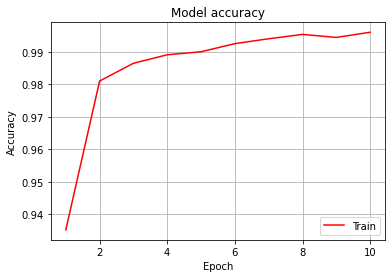

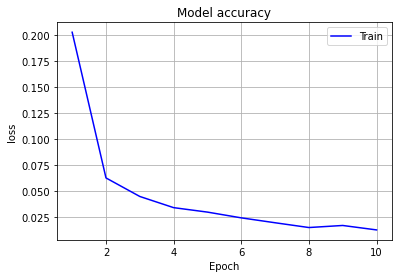

In [36]:
print('Test err:  %4.2f %%  time: %4.2f min'% (err[1],tn/60))

plt.plot(list(range(1,len(h.history['accuracy'])+1)),h.history['accuracy'],'r')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(('Train', 'Validation', 'Test'), loc='lower right')
plt.grid()
plt.show()
plt.plot(list(range(1,len(h.history['loss'])+1)),h.history['loss'],'b')
plt.title('Model accuracy')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(('Train', 'Validation', 'Test'), loc='upper right')
plt.grid()
plt.show()

In [37]:
CNN = Sequential()
CNN.add(Conv2D(6, kernel_size=(5, 5), activation=tf.keras.layers.ELU(), input_shape=(28,28,1)))
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Conv2D(16, (5, 5), activation=tf.keras.layers.ELU()))
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Flatten())
# add 3 hiden layers 
# TO DO
CNN.add(Dense(units=200, activation=tf.keras.layers.ELU()))
CNN.add(Dense(units=84, activation=tf.keras.layers.ELU()))
CNN.add(Dense(units=10, activation='softmax'))

CNN.summary()
CNN.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=False),metrics=['accuracy'])



t0=time.time()

h = CNN.fit(training_set.X_train, training_set.Y_train, epochs=10, verbose=0)

tn = time.time()-t0; 
print('total computing time: '+str(tn))

score = CNN.evaluate(training_set.X_test, training_set.Y_test)  
err = 100*(1-np.array(score))
print('Test loss: %4.3f '%score[0])
print('Test err:  %4.2f %%'% err[1])


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 6)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 16)          2416      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 200)               51400     
_________________________________________________________________
dense_9 (Dense)              (None, 84)               

Test err:  0.94 %  time: 0.54 min


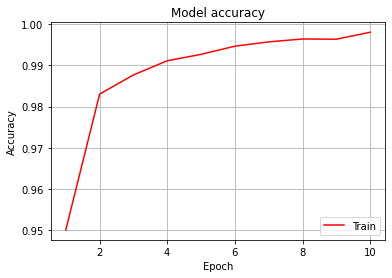

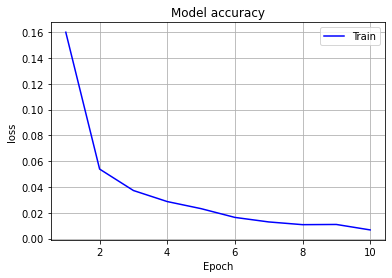

In [38]:
print('Test err:  %4.2f %%  time: %4.2f min'% (err[1],tn/60))

plt.plot(list(range(1,len(h.history['accuracy'])+1)),h.history['accuracy'],'r')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(('Train', 'Validation', 'Test'), loc='lower right')
plt.grid()
plt.show()
plt.plot(list(range(1,len(h.history['loss'])+1)),h.history['loss'],'b')
plt.title('Model accuracy')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(('Train', 'Validation', 'Test'), loc='upper right')
plt.grid()
plt.show()

> Create you own CNN model performing better performance than the proposed one while avoiding over-fitting and huge complexity network

> Test the different networks on [MNIST](http://yann.lecun.com/exdb/mnist/index.html) and [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist)

> Summarize the performance of the different networks in a Table that includes : architecture Name, Number of trained parameters, used optimizer, CPU Time, GPU Time, and Accuracy/Error 